In [1]:
TTS_PATH = "/vm/"

In [2]:
import os
import sys
sys.path.append(TTS_PATH) # set this if TTS is not installed globally
import glob
import librosa
import numpy as np
import pandas as pd
from scipy.stats import norm
from tqdm import tqdm_notebook as tqdm
from multiprocessing import Pool
from matplotlib import pylab as plt
from collections import Counter
from TTS.datasets.preprocess import *
%matplotlib inline

In [3]:
DATA_PATH = "/y/south-park-1-to-20/"
META_DATA = "metadata.csv"
NUM_PROC = 8

In [4]:
# use your own preprocessor at this stage - TTS/datasets/proprocess.py
items = ljspeech(DATA_PATH, META_DATA)
print(" > Number of audio files: {}".format(len(items)))

 > Number of audio files: 11087


In [5]:
# check wavs if exist
wav_files = []
for item in items:
    wav_file = item[1].strip()
    wav_files.append(wav_file)
    if not os.path.exists(wav_file):
        print(waf_path)

In [6]:
# show duplicate items
c = Counter(wav_files)
print([item for item, count in c.items() if count > 1])

[]


In [7]:
def load_item(item):
    file_name = item[1].strip()
    text = item[0].strip()
    audio = librosa.load(file_name, sr=None)
    sr = audio[1]
    audio = audio[0]
    audio_len = len(audio) / sr
    text_len = len(text)
    return file_name, text, text_len, audio, audio_len

# This will take a while depending on size of dataset
if NUM_PROC == 1:
    data = []
    for m in tqdm(items):
        data += [load_item(m)]
else:
    with Pool(8) as p:
        data = list(tqdm(p.imap(load_item, items), total=len(items)))

In [8]:
# count words in the dataset
w_count = Counter()
for item in tqdm(data):
    text = item[1].lower().strip()
    for word in text.split():
        w_count[word] += 1
print(" > Number of words: {}".format(len(w_count)))


 > Number of words: 10709


In [9]:
text_vs_durs = {}  # text length vs audio duration
text_len_counter = Counter()  # number of sentences with the keyed length
for item in tqdm(data):
    text = item[1].lower().strip()
    text_len = len(text)
    text_len_counter[text_len] += 1
    audio_len = item[-1]
    try:
        text_vs_durs[text_len] += [audio_len]
    except:
        text_vs_durs[text_len] = [audio_len]

In [10]:
# text_len vs avg_audio_len, median_audio_len, std_audio_len
text_vs_avg = {}
text_vs_median = {}
text_vs_std = {}
for key, durs in text_vs_durs.items():
    text_vs_avg[key] = np.mean(durs)
    text_vs_median[key] = np.median(durs)
    text_vs_std[key] = np.std(durs)

### Avg audio length per char

In [11]:
#AO: assuming this is audio length < 2 seconds; examining item 1 shows it is completely correct; a 2 second threshold is probably a poor choice for dialogue
for item in data:
    #if item[-1] < 2:
    if item[-1] < .4:
        print(item)

In [12]:
sec_per_chars = []
for item in data:
    text = item[1]
    dur = item[-1]
    sec_per_char = dur / len(text)
    sec_per_chars.append(sec_per_char)
# sec_per_char /= len(data)
# print(sec_per_char)

In [13]:
mean = np.mean(sec_per_chars)
std = np.std(sec_per_chars)
print(mean)
print(std)

0.058476624236823475
0.07968556176588433


In [14]:
dist = norm(mean, std)

# find irregular instances long or short voice durations
for item in data:
    text = item[1]
    dur = item[-1]
    sec_per_char = dur / len(text)
    pdf =norm.pdf(sec_per_char)
    if pdf < 0.39:
        print(item)

('/y/south-park-1-to-20/wavs/Cartman-1-1-743990-751190.wav', 'YOU ARE MAKING IT UP!', 21, array([-0.00015259,  0.00061035, -0.00064087, ...,  0.01721191,
        0.00228882,  0.00695801], dtype=float32), 7.2)
('/y/south-park-1-to-20/wavs/Cartman-1-1-818210-835440.wav', 'AND I KNOW THAT I AM NOT UNDER ALIEN CONTROL.', 45, array([-2.4414062e-04,  2.1362305e-04,  0.0000000e+00, ...,
       -6.1035156e-05,  2.4414062e-04,  3.9672852e-04], dtype=float32), 17.23)
('/y/south-park-1-to-20/wavs/Cartman-1-1-889400-901500.wav', "GOD DAMN IT, I DIDN'T HAVE AN ANAL PROBE!", 41, array([-1.16882324e-02, -1.21765137e-02, -1.21154785e-02, ...,
        3.05175781e-04,  6.10351562e-05,  7.62939453e-04], dtype=float32), 12.1)
('/y/south-park-1-to-20/wavs/Cartman-1-1-1068420-1071270.wav', 'BAD KITTY!', 10, array([-0.00048828, -0.00012207, -0.00018311, ...,  0.00039673,
       -0.0071106 ,  0.04785156], dtype=float32), 2.85)
('/y/south-park-1-to-20/wavs/Cartman-1-1-1618770-1627959.wav', "SHUT UP! I'M NOT SC

### Plot Dataset Statistics

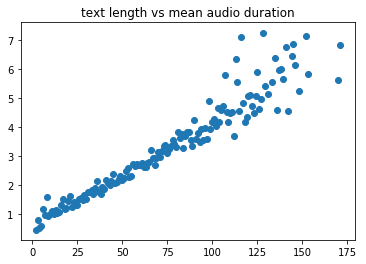

In [15]:
plt.title("text length vs mean audio duration")
plt.scatter(list(text_vs_avg.keys()), list(text_vs_avg.values()))

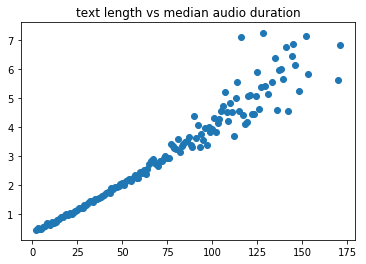

In [16]:
plt.title("text length vs median audio duration")
plt.scatter(list(text_vs_median.keys()), list(text_vs_median.values()))

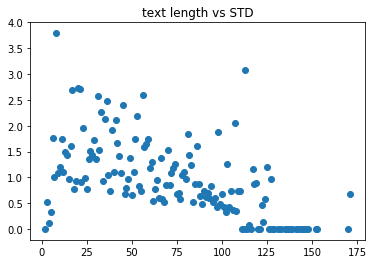

In [17]:
plt.title("text length vs STD")
plt.scatter(list(text_vs_std.keys()), list(text_vs_std.values()))

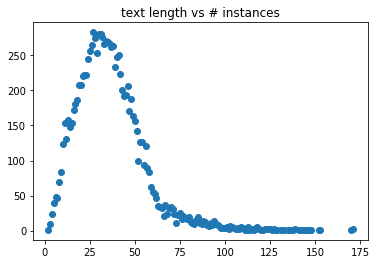

In [18]:
plt.title("text length vs # instances")
plt.scatter(list(text_len_counter.keys()), list(text_len_counter.values()))

### Check words frequencies

In [19]:
w_count_df = pd.DataFrame.from_dict(w_count, orient='index')
w_count_df.sort_values(0, ascending=False, inplace=True)

In [20]:
w_count_df

,0
you,2264
the,2170
i,2103
to,1889
a,1470
and,1296
of,828
we,794
is,775
that,759


In [21]:
# check a certain word
w_count_df.at['minute', 0]

7

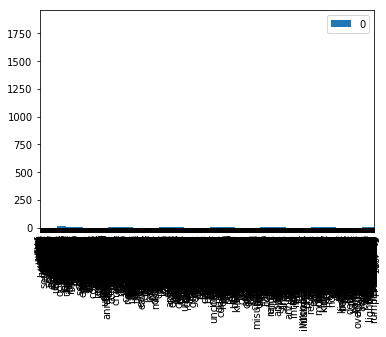

In [68]:
# fequency bar plot - it takes time!!
w_count_df.plot.bar()